In [1]:

#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse

%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np

import seaborn as sns
from warnings import filterwarnings
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale



import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated





WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:



def get_data(granularity, instrument, save_csv=False):
    client = API(access_token="e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d")
    

    params = {

        "granularity": granularity,
        "count": 1000,
     }
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
            rv = client.request(r)
            results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                        "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                       "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                       } for candle in r.response.get('candles')]
            df = df.append(pd.DataFrame(results), ignore_index=True)

    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
df = get_data(instrument = "DE30_EUR", granularity = "D", save_csv=True)
df.head()
df.dropna()

,Open,High,Low,Close,Volume
Date,,,,,
2018-07-08T21:00:00,12564.6,12575.0,12490.3,12573.6,76058.0
2018-07-09T21:00:00,12586.6,12644.6,12531.5,12613.3,76655.0
2018-07-10T21:00:00,12498.0,12523.1,12391.8,12430.3,116588.0
2018-07-11T21:00:00,12464.8,12518.4,12409.2,12515.8,92902.0
2018-07-12T21:00:00,12542.9,12587.6,12499.8,12546.4,82619.0
...,...,...,...,...,...
2022-06-07T21:00:00,14586.0,14630.5,14352.6,14383.6,135723.0
2022-06-08T21:00:00,14382.0,14425.0,14086.6,14089.6,169418.0
2022-06-09T21:00:00,14095.1,14131.2,13740.2,13787.2,219399.0


In [5]:
df = df.reset_index()

X= (df['Close']).values
Y= (df['Close']).index.values


X.shape, Y.shape

((1000,), (1000,))

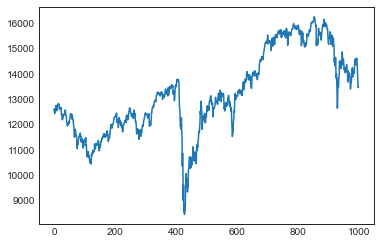

In [6]:
plt.plot(X)


In [7]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X)
        ann_output = pm.Data('ann_output', Y)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X, Y)

IndexError: tuple index out of range

In [ ]:
%%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

In [ ]:
plt.plot(inference.hist, label='new ADVI', alpha=.6)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [ ]:
trace = approx.sample(draws=5000)

In [ ]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(
        trace, samples=500, progressbar=False, model=neural_network
    )

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc["out"].mean(axis=0) > 0.5


def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5



In [ ]:
pred = sample_proba(X, 500).mean(0) > 0.5

In [ ]:
pred.shape

In [ ]:
print('Accuracy = {}%'.format((Y == pred).mean() * 100))

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)



In [ ]:
ppc = sample_proba(grid_2d, 500)



In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");



In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");



In [ ]:
pm.traceplot(trace);

In [ ]:
import arviz as az

az.plot_posterior(
    trace, var_names=["w_2_out"]
);